In [278]:
import numpy as np
from lmfit import Model
import lmfit
from scipy.optimize import curve_fit
from os.path import normpath, dirname
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import pandas as pd
import json
import git
import matplotlib.pyplot as plt
from cycler import cycler
from math import ceil
from itertools import chain


In [279]:
label_size = 22
plt.rcParams.update(
    {
        "font.size": label_size,
        "legend.title_fontsize": 22,
        "legend.fontsize": 22,
        "axes.labelsize": label_size,
        "xtick.labelsize": label_size,
        "ytick.labelsize": label_size,
        "axes.labelpad": 4,
        "lines.markersize": 13,
        "lines.linewidth": 2,
    }
)

# This will bind the paths from localSettings.json to objects in a class named paths
# usage: paths.<name>
class JSONObject:
    def __init__(self, dict):
        vars(self).update(dict)
def get_header(filename):
    with open(filename, "r") as f:
        for line in f:
            if line.startswith("#"):
                header = line
            else:
                break  # stop when there are no more #

        header = header[1:].strip().split()
    return header


def na(array):
    return np.array(array)

    
def round_to_n(data, n=1):
    if n != 1:
        return [round(x, -int(floor(log10(x))) + (n - 1)) for x in data]
    else:
        return [round(x, -int(floor(log10(x)))) for x in data]

# returns data and error rounded to significance of error
def round_to_reference(data, ref, n):
    ref = round_to_n(ref, n)
    return ([round(x, -int(floor(log10(y))) + (n - 1)) for (x,y) in zip(data, ref)], ref)

def gaussian(x, amplitude, mean, sigma):
    return (amplitude/(np.sqrt(2*np.pi)))*np.exp(-(x-mean)**2/(2*sigma**2))

rtr = round_to_reference

# Root Directory of Repository
repo = git.Repo(".", search_parent_directories=True).working_dir
with open(normpath(repo + "/localSettings.json"), "r") as f:
    path_data = f.read()
paths = json.loads(path_data, object_hook=JSONObject)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors = colors + ['b', 'g', 'm']

N: 70, Peak: (c,find) = (5.0, 0.249777572577)
N: 100, Peak: (c,find) = (4.6, 0.249692490327)
N: 120, Peak: (c,find) = (4.4, 0.249759531178)
N: 140, Peak: (c,find) = (4.2, 0.249152750347)
N: 180, Peak: (c,find) = (4.0, 0.248427965641)
N: 200, Peak: (c,find) = (4.0, 0.246925065444)
N: 250, Peak: (c,find) = (3.8, 0.249809594191)


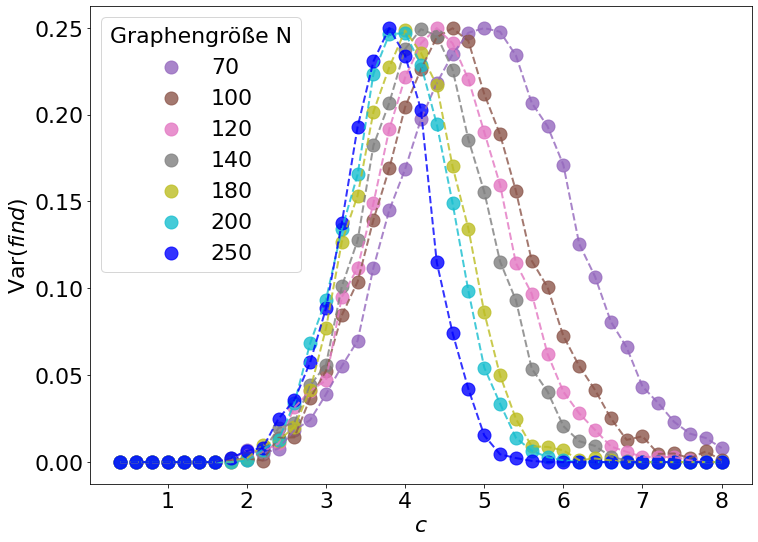

In [280]:
N = [70, 100, 120, 140, 180, 200, 250]
default_cycler = cycler(color=colors)
fig, ax = plt.subplots(figsize=(11,8), tight_layout=True)

for n, sty in zip(N,default_cycler[4:]):
    path = normpath(paths.Modul4+f'/Aufg5/Aufg6/VC_n{n}_means_m{int(2*n/10)}-{int(4*n)}_s1001-2001_add1_max_m100000_search5_CP.dat')
    header = get_header(path)
    header.append("temp") # Because in the file we first have a space, which is detected as a NaN column
    data_mod4 = pd.read_csv(path, sep=" ", comment='#', names=header, skipinitialspace=True)
    data_mod4.drop('temp', axis=1, inplace=True)

    # ax.errorbar(data_mod4['c'], data_mod4['Var(find)'], data_mod4['Var(find)_err'], **sty, zorder=3, label=f"{n}", fmt="o", ecolor="black", elinewidth=3, capsize=6, fillstyle="none", markeredgewidth=2)
    ax.scatter(data_mod4['c'], data_mod4['Var(find)'], **sty, alpha=0.8, zorder=2, label=f"{n}")    
    ax.plot(data_mod4['c'], data_mod4['Var(find)'], **sty, ls = "--", alpha=0.8, zorder=2)
    idx_max = data_mod4[['Var(find)']].idxmax()
    print(f'N: {n}, Peak: (c,find) = ({float(data_mod4["c"][idx_max])}, {float(data_mod4["Var(find)"][idx_max])})')

ax.set_xlabel('$c$')
ax.set_ylabel('Var($find$)')
# ax.set_xlim(1,5)
ax.legend(title="Graphengröße N")
plt.savefig('Abb/Modul4/Mod4_CP_var.png')

N=70, Peak_c = 4.981474142503977
N=100, Peak_c = 4.540790758481975
N=120, Peak_c = 4.405387725791049
N=140, Peak_c = 4.247547309148745
N=180, Peak_c = 4.022825912699128
N=200, Peak_c = 3.921697908722958
N=250, Peak_c = 3.7832858661540567


No handles with labels found to put in legend.


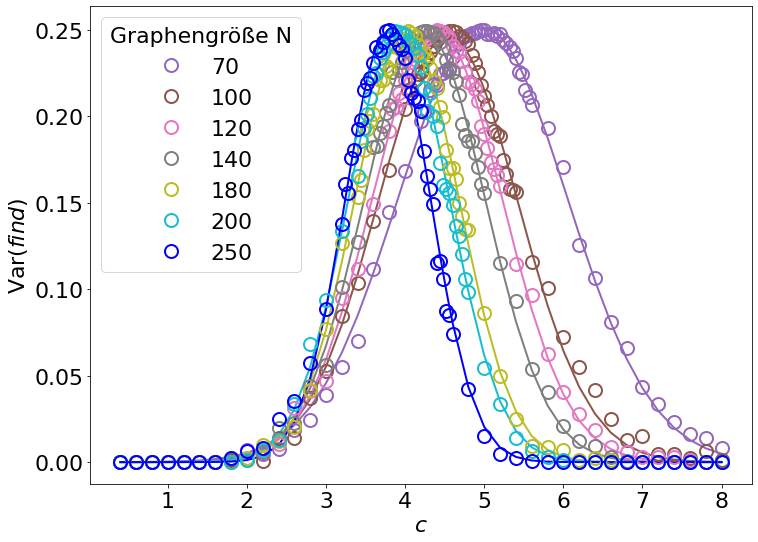

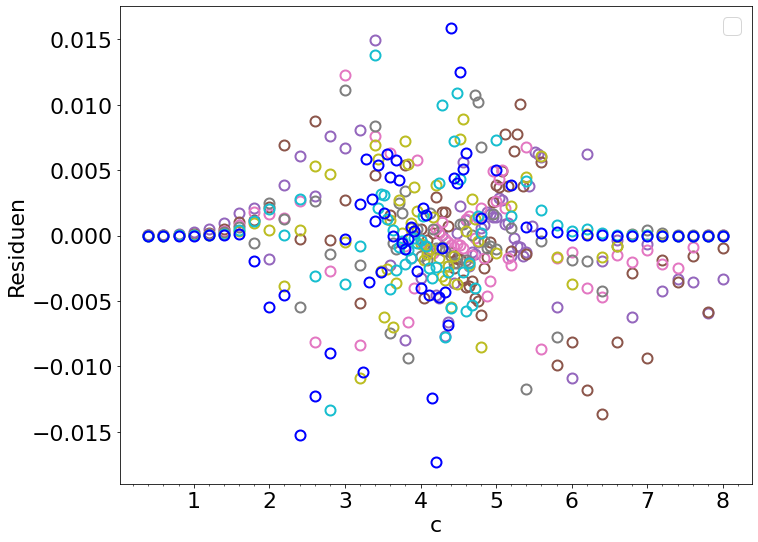

In [291]:
# Extra 0.002 due to errors in ceil otherwise
subtract_c = [0, 0.2, 0.4, 0.6, 0.8, 0.802, 1.002] # For different starting and end values of c_init/c_final
N = [70,100,120,140, 180, 200, 250]
Peaks = np.array([])
Peaks_error = np.array([])
c_init = np.array([4.24, 4.28, 4.32, 4.36])
c_final = c_init + 1.2
default_cycler = cycler(color=colors)
fig, ax = plt.subplots(figsize=(11,8), tight_layout=True)
fig2, ax2 = plt.subplots(figsize=(11,8), tight_layout=True)
ax2.set_ylabel('Residuen')
ax2.set_xlabel('c')
ax2.xaxis.set_minor_locator(AutoMinorLocator())

for n, sty, sub_c in zip(N, default_cycler[4:], subtract_c):
    df = pd.DataFrame(columns=['c', 'Var(find)', 'Var(find)_err'])
    c, var_find, var_find_err = [], [], []
    for ci, cf in zip(c_init, c_final):
        m_init = ceil((ci-sub_c)/2*n)
        m_final = ceil((cf-sub_c)/2*n)

        # Get Data and append
        path = normpath(paths.Modul4+f'/Aufg5/FinerAufg5/Average/VC_n{n}_means_m{int(m_init)}-{int(m_final)}_s1001-2001_add1_max_m100000_search5_CP.dat')
        header = get_header(path)
        header.append("temp") # Because in the file we first have a space, which is detected as a NaN column
        data_mod4 = pd.read_csv(path, sep=" ", comment='#', names=header, skipinitialspace=True)
        data_mod4.drop('temp', axis=1, inplace=True)
        c_float = np.linspace(ci-sub_c, cf-sub_c, len(data_mod4['c']))
        c.append(c_float)
        var_find.append(data_mod4['Var(find)'])
        var_find_err.append(data_mod4['Var(find)_err'])
    
    # Get Data from the big simulation Delta_c = 0.2
    path = normpath(paths.Modul4+f'/Aufg5/Aufg6/VC_n{n}_means_m{int(2*n/10)}-{int(4*n)}_s1001-2001_add1_max_m100000_search5_CP.dat')
    header = get_header(path)
    header.append("temp") # Because in the file we first have a space, which is detected as a NaN column
    data_mod4 = pd.read_csv(path, sep=" ", comment='#', names=header, skipinitialspace=True)
    data_mod4.drop('temp', axis=1, inplace=True)
    c_float = np.linspace(data_mod4['c'].iloc[0], data_mod4['c'].iloc[-1], len(data_mod4['c']))
    c.append(c_float)
    var_find.append(data_mod4['Var(find)'])
    var_find_err.append(data_mod4['Var(find)_err'])

    c, var_find, var_find_err = list(chain(*c)), list(chain(*var_find)), list(chain(*var_find_err))
    df_all_data = pd.DataFrame.from_dict({'c': c, 'Var(find)': var_find, 'Var(find)_err': var_find_err}).sort_values('c')
    # ax.scatter(df_all_data['c'], df_all_data['Var(find)'], **sty, alpha=0.8, zorder=2, label=f"{n}")    

    # Now fit Gaussian to it
    # model = Model(gaussian)
    # params = model.make_params(amplitude=np.max(var_find), center=np.mean(c), sigma=1)
    # result = model.fit(df_all_data['Var(find)'], params, x=df_all_data['c'])
    # print(result.fit_report())

    mod = lmfit.models.GaussianModel()
    pars = mod.make_params(c=0.25, center=2, sigma=1, amplitude=0.25)

    out = mod.fit(df_all_data['Var(find)'], pars, x=df_all_data['c'])
    # print(out.fit_report())
    peak = out.params["center"].value
    peak_error = out.params["center"].stderr

    Peaks = np.append(Peaks, peak)
    Peaks_error = np.append(Peaks_error, peak_error)
    print(f'N={n}, Peak_c = {peak}')
    ax.plot(df_all_data['c'], out.best_fit, **sty)
    ax.errorbar(df_all_data['c'], df_all_data['Var(find)'], **sty, zorder=3, label=f"{n}", fmt="o", ecolor="black", elinewidth=3, capsize=6, fillstyle="none", markeredgewidth=2)

    ax2.errorbar(df_all_data['c'], out.residual, **sty, fmt="o", fillstyle='none', markeredgewidth=2, ms=10)

    # ax.plot(df_all_data['c'], df_all_data['Var(find)'], **sty, ls = "--", alpha=0.8, zorder=2)
    # idx_max = data_mod4[['Var(find)']].idxmax()
    # print(f'N: {n}, Peak: (c,find) = ({float(data_mod4["c"][idx_max])}, {float(data_mod4["Var(find)"][idx_max])})')

ax.set_xlabel('$c$')
ax.set_ylabel('Var($find$)')
# ax.set_xlim(1,5)
ax.legend(title="Graphengröße N")
fig.savefig('Abb/Modul4/Mod4_CP_var_Gaussian.png')

ax2.legend()
fig2.savefig('Abb/Modul4/Mod4_CP_var_Gaussian_Residuen.png')

[[Model]]
    Model(fit_function_N)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 7
    # variables        = 3
    chi-square         = 0.00171611
    reduced chi-square = 4.2903e-04
    Akaike info crit   = -52.1952476
    Bayesian info crit = -52.3575171
[[Variables]]
    c_infty:  2.25283546 +/- 0.47411306 (21.05%) (init = 5)
    a:        18.9486561 +/- 5.23682130 (27.64%) (init = 10)
    b:        0.45655101 +/- 0.10469951 (22.93%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b)       = 0.997
    C(c_infty, b) = 0.996
    C(c_infty, a) = 0.987


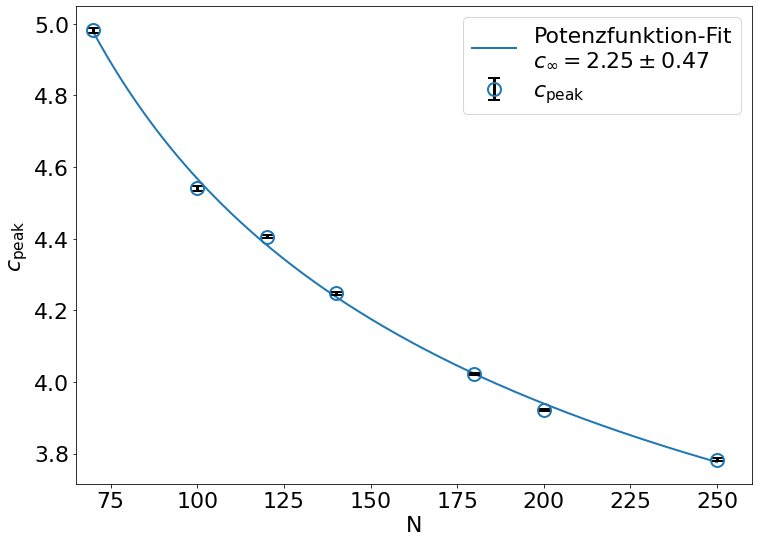

In [282]:
def fit_function_N (N, c_infty, a, b):
    return c_infty + a*N**(-b)

N = np.array([70,100,120,140, 180, 200, 250])
N_all = np.linspace(70,250,179)
fig, ax = plt.subplots(figsize=(11,8), tight_layout=True)

amodel = Model(fit_function_N)
params = amodel.make_params(c_infty=5, a=10, b=0.1)
result = amodel.fit(Peaks, params, N=N)
# $\chi^2={{{result.redchi:.2e}}}$
ax.plot(N_all, result.eval(result.params, N=N_all), label=f'Potenzfunktion-Fit\n$c_{{\infty}}={{{result.params["c_infty"].value:.2f}}}\pm {{{result.params["c_infty"].stderr:.2f}}}$')

print(result.fit_report())
ax.set_xlim(65,260)
ax.errorbar(N, Peaks, Peaks_error, zorder=3, label=f"$c_{{\\mathrm{{peak}}}}$", fmt="o", ecolor="black", elinewidth=3, capsize=6, fillstyle="none", markeredgewidth=2)
ax.set_xlabel('N')
ax.set_ylabel('$c_{{\\mathrm{{peak}}}}$')
ax.legend()
plt.savefig(f'Abb/Modul4/Mod4__Fit_c_infty.png')


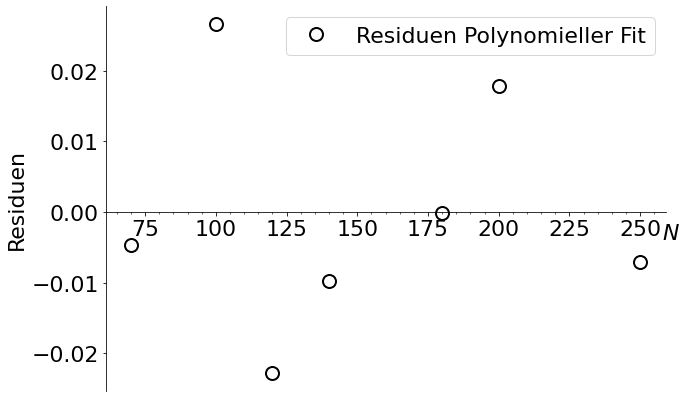

In [283]:
fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
ax.errorbar(N, result.residual, label=f'Residuen Polynomieller Fit', c="k", fmt="o", ecolor="k", fillstyle="none", markeredgewidth=2)
plt.xlabel('$N$', horizontalalignment='right', verticalalignment='bottom', x=1.025)
ax.set_ylabel('Residuen')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.legend()
plt.savefig(f'Abb/Modul4/Mod4_Residuen_Fit_c_infty.png')